### Notebook to train a parametric LSTM for latent space dynamics of a 1D Burgers example
The latent space representation is obtained using a pre-trained advection-aware autoencoder that is trained on 1D Burgers equation solution snapshots parametrized with varying values of Re

Consider the one-dimensional viscous Burgers' equation with Dirichlet boundary conditions which can be represented as 
\begin{align}
\dot{u} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},\\
u(x,0) = u_0, \qquad x \in [0,L], \qquad u(0,t) = u(L.t) = 0
\end{align}

Consider the initial condition
\begin{align}
u(x,0) = \frac{x}{1 + \sqrt{\frac{1}{t_0}} \exp{\left(Re \frac{x^2}{4} \right)}},
\end{align}

Set $L=1$ and maximum time $t_{max} = 2$. An analytical solution exists and is given by 
\begin{align}
u(x,t) =  \frac{\frac{x}{t+1}}{1 + \sqrt{\frac{t+1}{t_0}} \exp{\left(Re \frac{x^2}{4t+4} \right)}}
\end{align}

where $t_0 = \exp{(Re/8)}$ and $Re = 1/\nu$. 
The spatio-temporal domain $[0,L]\times[0,t_{max}]$ is uniformly discretized into $200$ grid points and $500$ time points.

In [1]:
## Load modules
%matplotlib inline

import numpy as np
from numpy import array
import scipy
import os
import gc
import argparse
import time
import importlib
from importlib import reload
from pathlib import Path
import sys

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

import tensorflow as tf
print("Tensorflow v"+str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: # in ['2.2.0','2.3.0']:
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float32')
    tf.debugging.set_log_device_placement(True)
    
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Dense, LSTM, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import logging
tf.get_logger().setLevel(logging.ERROR)

np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, 
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x','D','H','v','*'])

try:
    base_dir.exists()
except:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent
data_dir = base_dir / "data" / "burgers1d"
fig_dir = base_dir / "figures"
utils_dir = base_dir / "src" / "utils"
nn_dir = base_dir / "src" / "nn_model"
work_dir = base_dir / "examples"
model_dir = base_dir / "data" / "saved_models" 

sys.path.append(str(utils_dir.absolute()))
sys.path.append(str(nn_dir.absolute()))

import data_utils as du
import tf_utils as tu
import plot_utils as pu
import aa_autoencoder as aa


# try:
#     os.listdir(base_dir)
# except:
#     base_dir = os.getcwd()
# utils_dir  = os.path.join(base_dir,'../src/utils')
# nn_dir  = os.path.join(base_dir,'../src/nn_model')
# work_dir = os.path.join(base_dir,'../examples')
# data_dir = os.path.join(base_dir,'../data')
# model_dir = os.path.join(base_dir,'../data/saved_models/')
# fig_dir  = os.path.join(base_dir,'../figures/')


# os.chdir(utils_dir)
# import data_utils as du
# import tf_utils as tu
# import plot_utils as pu

# os.chdir(nn_dir)
# import aa_autoencoder as aa
# os.chdir(work_dir)



Tensorflow v2.5.0


In [2]:
device = 'gpu:0' # select gpu:# or cpu:#

param_list = [50, 150, 300, 500, 400, 600]; flag = 'Re';    
param_train = [50, 150, 300, 500,]; param_test = [400, 600]



In [3]:
## Load snapshot data
model ='Burgers1D'
soln_names = ['burgers']

snap_data = {}; times_offline = {}
Re = {}; 
snap_start = {}; snap_end = {}

for indx,val in enumerate(param_train):
    if flag == 'Re':
        datafile = 'Burgers1d_Nx200_Nt500_Re%.2f'%(val)+'.npz'
    data = np.load(os.path.join(data_dir, datafile))
   
    Re[indx] = float(datafile.split('_Re')[1].split('.npz')[0])
    print("\n%d: Loading snapshots for Re = %.2f "%(indx, Re[indx]))
    
    snap_data[indx], times_offline[indx], nodes, Nx, Ny, snap_start[indx], snap_end[indx] = du.read_data(data, soln_names)
    
del data
gc.collect()


0: Loading snapshots for Re = 50.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

1: Loading snapshots for Re = 150.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

2: Loading snapshots for Re = 300.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

3: Loading snapshots for Re = 500.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins


214

In [4]:
## Prepare training snapshots

Nn = Nx

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=1

## Subsample snapshots for building reduced basis
Nt = {}
Nt_train = {}
train_end = {}
for indx,val in enumerate(param_train):
    Nt[indx] = times_offline[indx].size
    train_end[indx] = int(Nt[indx]*1.00)
    Nt_train[indx] = times_offline[indx][:train_end[indx]+1:snap_incr].size
    print('{5}: Using {0} training snapshots for {1} = {2:.2f} in time interval [{3:.2f},{4:.2f}] mins'.format(
            Nt_train[indx], flag, param_train[indx], times_offline[indx][:train_end[indx]+1:snap_incr][0]/60, 
            times_offline[indx][:train_end[indx]+1:snap_incr][-1]/60, indx))




0: Using 500 training snapshots for Re = 50.00 in time interval [0.00,0.03] mins
1: Using 500 training snapshots for Re = 150.00 in time interval [0.00,0.03] mins
2: Using 500 training snapshots for Re = 300.00 in time interval [0.00,0.03] mins
3: Using 500 training snapshots for Re = 500.00 in time interval [0.00,0.03] mins


In [5]:
def set_label(key):
    if key == 'burgers':
        ky = 'u'
    
    return ky

In [6]:
## Load shifted snapshots   
print("Generating shifted snapshots -----\n")

shifted_snap = {}
for indx,val in enumerate(param_train):
    
    shifted_snap[indx] = {}
    for key in soln_names:
        tmp = snap_data[indx][key][:,int(Nt[indx]//2)]
        shifted_snap[indx][key] = np.outer(tmp,np.ones(Nt[indx]))

        print("%d: Generating %d shifted snapshots for Re = %d, key = %s"%(indx, 
                                                            shifted_snap[indx][key].shape[1], 
                                                            Re[indx], key))
        


Generating shifted snapshots -----

0: Generating 500 shifted snapshots for Re = 50, key = burgers
1: Generating 500 shifted snapshots for Re = 150, key = burgers
2: Generating 500 shifted snapshots for Re = 300, key = burgers
3: Generating 500 shifted snapshots for Re = 500, key = burgers


In [7]:
## Load AE model

load_ae_model = False

if load_ae_model:
    pre_trained_dir = model_dir / "ae_param_models" / "saved_model_AA3"
 
    mnum_ae = str(pre_trained_dir).split('saved_model_')[1]
    if mnum_ae == 'AA3':
        augment_out = True
    elif mnum_ae == 'AA4':
        augment_out = True
    ae_model = 'saved_model_%s'%mnum_ae
    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    
    u_autoencoder, ae_training = aa.load_model(pre_trained_dir,mnum_ae)
    
    print(ae_training['msg'])
 
    loss_ae = ae_training['loss']
    vloss_ae = ae_training['valloss'] 
    sloss_ae = ae_training['shiftloss'] 
    rloss_ae = ae_training['reconloss'] 
    lr_ae = ae_training['lr']
    epochs_ae = ae_training['epochs']
    u_max = ae_training['umax']
    u_min = ae_training['umin']
    augment_out = ae_training['augment']
    
    u_autoencoder.summary()



Re = [50, 150, 300, 500], train_end = 1.00*T,
Trains both shift and true decoder, Time = 53m 57s,
Step decay LR scheduler starting from 5.00e-04, Batch Size = 24,
Decaying 10% every 330 epochs. Trained for 5000 epochs,
For epochs <=1500: Loss = 0.02*Shift + 0.96*True,
For epochs > 1500: Loss = 0.24*Shift + 0.74*True,
90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],
Both Encoder input and Decoder output are augmented by parameter value

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  10355     
_________________________________________________________________
shift (Shift)                multiple                  10551     
_________________________________________________________________
decoder (Decoder)            multiple                  10551     
Total params: 31,457
Trainable params: 31,457
Non-trainable params:

In [8]:
###  ***** Prepare Autoencoder input data *******
## 1. Concatenate parametric snapshots to prepare
##    input features for AA Autoencoder training

u = np.empty((0,Nn),)
u_shift = np.empty((0,Nn),)
key = soln_names[0]

for indx,val in enumerate(param_train):
    u_snap = snap_data[indx][key][:,:train_end[indx]+1:snap_incr].T    
    u = np.vstack((u,u_snap))
    u_shift_snap = shifted_snap[indx][key][:,:train_end[indx]+1:snap_incr].T
    u_shift = np.vstack((u_shift,u_shift_snap))
    

validation_data = False
skip_start = snap_incr//2
if validation_data:
    u_val = np.empty((0,Nn),)
    u_val_shift = np.empty((0,Nn),)
    for indx,val in enumerate(param_train):
        u_val_snap = snap_data[indx][key][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val_shift_snap = shifted_snap[indx][key][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val = np.vstack((u_val, u_val_snap))
        u_val_shift = np.vstack((u_val_shift, u_val_shift_snap))
    
    

In [9]:
## Scale Input Features to lie between [0,1]

scaling=True

if scaling:
    u, u_shift, _, _ = du.data_scaler(u, u_shift, u_max, u_min)

    if validation_data:
        u_val, u_val_shift, _, _ = du.data_scaler(u_val, u_val_shift, u_max, u_min)
        
else:
    u_max = np.maximum(u.max(), u_shift.max()); u_min = np.minimum(u.min(), u_shift.min())

    

In [10]:
###  ***** Prepare Autoencoder input data *******
## 2. Augment input feature states with scaled 
##    parameter values

u_sigma = np.empty((0,1),)
u_shift_sigma = np.empty((0,1),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_train/p_max):
    u_sigma = np.vstack((u_sigma,val*np.ones((Nt_train[indx],1))))
    u_shift_sigma = np.vstack((u_shift_sigma,val*np.ones((Nt_train[indx],1)) ))
    
u = np.hstack(( u,u_sigma))
u_shift = np.hstack(( u_shift, u_shift_sigma))


if validation_data:
    u_val_sigma = np.empty((0,1),)
    u_val_shift_sigma = np.empty((0,1),)
    for indx,val in enumerate(param_train/p_max):
        val_steps = np.minimum(times_offline[indx][skip_start:train_end[indx]+1:snap_incr].size, Nt_train[indx])
        u_val_sigma = np.vstack((u_val_sigma, val*np.ones((val_steps,1)) ))
        u_val_shift_sigma = np.vstack((u_val_shift_sigma, val*np.ones((val_steps,1)) ))
        
        
    u_val = np.hstack(( u_val, u_val_sigma))
    u_val_shift = np.hstack(( u_val_shift, u_val_shift_sigma))



In [11]:
encoded_u = u_autoencoder.encoder(u).numpy()
if augment_out:
    shift_u = u_autoencoder.shift(encoded_u).numpy()[:,:-1]
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()[:,:-1]
else:
    shift_u = u_autoencoder.shift(encoded_u).numpy()
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()

encoded = encoded_u

latent_dim_u = 5
n_neurons = latent_dim_u


print('\n*********AE shifted decoder reconstruction error*********\n')
print('u  Reconstruction MSE: ' + str(np.mean(np.square(du.scaler_inverse(shift_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u_shift[:,:-1], u_max, u_min, scaling=scaling)))))

print('\n*********AE inverse decoder reconstruction error*********\n')
print('u  Reconstruction MSE: ' + str(np.mean(np.square(du.scaler_inverse(decoded_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u[:,:-1], u_max, u_min, scaling=scaling)))))




*********AE shifted decoder reconstruction error*********

u  Reconstruction MSE: 5.537013233954267e-07

*********AE inverse decoder reconstruction error*********

u  Reconstruction MSE: 1.058414066863324e-06


In [12]:
##### LSTM Model configuration

activation_lstm='swish'
loss_fn = tf.keras.losses.MeanSquaredError()
n_epochs_lstm = 50000
lstm_steps = 8
hidden_lstm = 128



In [13]:
# define model

class LSTMDynamics(tf.keras.models.Model):
    def __init__(self, n_steps, n_features, hidden_dim, act):
        super(LSTMDynamics, self).__init__()
        self.lstm = Sequential()
        self.lstm.add(LSTM(hidden_dim, activation=act, return_sequences=True, input_shape=(n_steps, n_features+1) ))
        self.lstm.add(LSTM(hidden_dim, activation=act, return_sequences=True,))
        self.lstm.add(LSTM(hidden_dim, activation=act))
        self.lstm.add(Dense(n_features+1))
        
    def call(self, x):
        pred = self.lstm(x)
        return pred
    

In [14]:
## Custom Training Loop
def train_LSTMDynamics(epochs, encoded_u_train, latent_dim, actvn, hidden_lstm, Nt, **kwargs):
    
    try:
        learn_rate = kwargs['lr']
    except:
        learn_rate = 0.0001
    try:
        batch_size = kwargs['batch_size']
    except:
        batch_size = 64
        
    try:
        lstm_steps = kwargs['n_steps']
    except:
        lstm_steps = 2
    
    try:
        decay_factor = kwargs['decay'][0]; decay_rate = kwargs['decay'][1]
    except:
        decay_factor = 15; decay_rate = 0.9
    try: 
        learning_rate_decay = kwargs['lr_decay']
        init_learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(learn_rate,
                                                        decay_steps=epochs*Nt//batch_size//decay_factor,
                                                        decay_rate=decay_rate,
                                                        staircase=True)
    except:
        init_learn_rate = learn_rate
        
    try:
        lb = kwargs['loss_lb']
    except:
        lb = 0.9
    
    Nt_train = kwargs['Nt_train']
    param_list = kwargs['p_list']
    
    model = LSTMDynamics(lstm_steps, latent_dim, hidden_lstm, actvn)
    optimizer = tf.keras.optimizers.Adam(learning_rate=init_learn_rate)
    
    train_loss = []; val_loss = []
    shift_loss = []; recon_loss = []
    lstm_loss = []; lr = []
    start_time = time.time()
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,))
        if not learning_rate_decay:
            batch_size = batch_size + 1
        u_train = tu.gen_batch_lstm(encoded_u_train, batch_size, Nt_train, param_list, msg=False)

        # Iterate over the batches of the dataset.
        train_loss_value = 0; 
        lstm_loss_value = 0;
        batched_data = 0
        for step_train, x_batch_train in enumerate(u_train):
            
            x_batch_train = tf.cast(x_batch_train, tf.float32)
            batched_data +=x_batch_train.shape[0]
            
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Split into sequences for LSTM
                encoded_input, encoded_target = tu.split_sequence_multi(x_batch_train, lstm_steps)

                if encoded_target.shape[0] == 0:
                    lstm_flag = 0                  
                    lstm = tf.convert_to_tensor(encoded_input[lstm_steps:])
                else:
                    lstm_flag = 1
                    
                    # LSTM time marching in encoded space
                    lstm = model.lstm(encoded_input, training=True)
                
                ## Loss wrt to LSTM evaluation on encoded input
                loss = tu.comb_loss(encoded_target, lstm, lb=lb) #\
 
                if lstm_flag == 0:
                    loss_value = 0
                else:
                    loss_value = loss 

            
            train_loss_value += loss_value
            if lstm_flag == 0:
                lstm_loss_value += 0
            else:
                lstm_loss_value += loss
                
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_variables,
                        unconnected_gradients=tf.UnconnectedGradients.ZERO) 
            ## Suppress warning about zero gradients for lstm training
            
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Log every 10 batches.
            if step_train % 10 == 0:
                print("Training loss for batch %d: LSTM %.6e"
                % ((step_train+1), float(loss) ) )
                print("Seen so far: %s samples" % (batched_data)) 
                
 
        train_loss.append((train_loss_value/(step_train + 1)).numpy())
        lstm_loss.append((lstm_loss_value/(step_train + 1)).numpy())
        
        if learning_rate_decay:
            print("Epoch %d, Training Loss: %.4e, LR: %.3e" 
                  % (epoch, float(train_loss[-1]),init_learn_rate(optimizer.iterations).numpy()))
            lr.append(init_learn_rate(optimizer.iterations).numpy())
        else:
            print("Epoch %d, Training Loss: %.4e, LR: %.3e" 
                  % (epoch, float(train_loss[-1]),learn_rate))
            lr.append(learn_rate)    
    
    end_time = time.time()
    print("****Total training time = {0}****\n".format(end_time - start_time))
    
    return model, train_loss, lstm_loss, lr



In [15]:
encoded_u_train = u_autoencoder.encoder(u).numpy()

batch_size = 150
size_buffer = max(list(Nt_train.values()))



In [16]:
load_lstm_model = False

if load_lstm_model:
    pre_trained_dir = model_dir / "lstm_param_models" / "saved_model_1"
    mnum_lstm = int(str(pre_trained_dir).split('saved_model_')[1])

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    u_lstm = tf.keras.models.load_model(pre_trained_dir / "u_lstm",compile=False)
    histdir = 'model_history_%d.npz'%mnum_lstm
    lstm_training = np.load(pre_trained_dir / histdir) 

    print(lstm_training['msg'])

    loss_u = lstm_training['loss']
    lloss_u = lstm_training['lstmloss'] 
    lr_u = lstm_training['lr']
    n_epochs_lstm = lstm_training['epochs']
    scaling_lstm = lstm_training['scaling']


Re = [50,150,300,500],
LSTM window = 8, 128 Neurons for 3 LSTM layers,
Trains LSTM in latent space, Epochs = 50000
Trains using AA-AE model AA3
0.9*NMSE + 0.1*Huber in latent space, No regularization,
LR scheduler starting from 1e-3, Batch = 150 
LR decaying by 20% every 2083 epochs
Swish activation, No Scaling for LSTM


In [17]:
try:
    scaling_lstm
    pass
except:
    scaling_lstm = False
    
    
if scaling_lstm:
    encoded_u_scaled, _, umax_latent, umin_latent = du.data_scaler(encoded_u_train, encoded_u_train,)
else:
    encoded_u_scaled = encoded_u_train

encoded_u_train_sigma = du.augment_state(encoded_u_scaled, param_train/p_max, Nt_train)



In [18]:

if not load_lstm_model:
    u_lstm, loss_u, lloss_u, lr_u = train_LSTMDynamics(n_epochs_lstm,
                                                encoded_u_train_sigma, latent_dim_u,
                                                activation_lstm, hidden_lstm,
                                                size_buffer, n_steps = lstm_steps,
                                                Nt_train = Nt_train, p_list = param_train,
                                                decay = [5, 0.75],
                                                batch_size = batch_size, loss_lb = 0.9,
                                                lr = 1e-3, lr_decay=True )



In [19]:
## Prediction visualization in latent space

param_num = 3

def select_variable(encoded_var, param_num):
    p_indx = sum(list(Nt_train.values())[:param_num]); 
    encoded = encoded_var[p_indx:p_indx+Nt_train[param_num],:]; ldim = latent_dim_u
    return encoded, ldim, p_indx


encoded_true, ldim, p_indx = select_variable(encoded_u_train, param_num)
if scaling_lstm:
    encoded_true_scaled, _,_,_ = du.data_scaler(encoded_true, encoded_true,umax_latent, umin_latent)
else:
    encoded_true_scaled = encoded_true


encoded_true_sigma = du.augment_state(encoded_true_scaled, [param_list[param_num]/p_max], {0:Nt_train[param_num]})
u_dynamics_input, u_dynamics_target = tu.split_sequence_multi(encoded_true_sigma, lstm_steps)
u_dynamics_pred = u_lstm.predict(u_dynamics_input)


print("===SAMPLE TARGET===")
print(u_dynamics_target[:2,:])
print("\n===SAMPLE PRED===")
print(u_dynamics_pred[:2,:])


===SAMPLE TARGET===
[[-0.88288271  2.63139033 -1.67029572 -1.46840394  2.70426202  0.83333333]
 [-0.89765406  2.63498902 -1.62364185 -1.43460357  2.73702359  0.83333333]]

===SAMPLE PRED===
[[-0.8828529  2.6317127 -1.6702762 -1.4687042  2.7039917  0.8331247]
 [-0.8979702  2.6349072 -1.6235564 -1.4344819  2.7371278  0.8331598]]


In [20]:
print("******LSTM reconstruction error*****")
print('$z$  Reconstruction MSE: ' + str(np.mean(np.square(u_dynamics_pred - u_dynamics_target))))


******LSTM reconstruction error*****
$z$  Reconstruction MSE: 6.104503425453444e-08


In [21]:
## Save the trained LSTM model

save_lstm_model = True
    
if save_lstm_model:
        
    savedir = model_dir / "lstm_param_models" / "saved_model_1"
    savedir.mkdir(parents=True, exist_ok=True)
    mnum_lstm = int(str(savedir).split('saved_model_')[1])
    
    ## To use TF SavedModel format with a custom training loop,
    ## call model.predict() on some input tensors first.
    ## Otherwise TF doesn't know the shape and dtype of input data
    ## it should be expecting, and thus cannot create it's weight 
    ## variables. When using model.fit() this step happens automatically.
#     test_predict = u_lstm.predict(u_input_test)

    u_lstm.save(savedir / "u_lstm")
    msg = 'Re = [50,150,300,500],'\
    +'\nLSTM window = %d, %d Neurons for 3 LSTM layers,'%(lstm_steps, hidden_lstm)\
    +'\nTrains LSTM in latent space, Epochs = %d'%(n_epochs_lstm)\
    +'\nTrains using AA-AE model %s'%mnum_ae\
    +'\n0.9*NMSE + 0.1*Huber in latent space, No regularization,' \
    +'\nLR scheduler starting from 1e-3, Batch = %d '%(batch_size)\
    +'\nLR decaying by 20% every 2083 epochs'\
    +'\nSwish activation, No Scaling for LSTM'
    print("\n===========")
    print(msg)
    histdir = 'model_history_%d.npz'%mnum_lstm
    
    np.savez_compressed(savedir / histdir, 
                        loss = loss_u, lstmloss = lloss_u, 
                        scaling = scaling_lstm,
                        lr = lr_u, epochs = n_epochs_lstm, msg=msg,
                        ae_model = ae_model, ldim = latent_dim_u)  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8, 128)            69120     
_________________________________________________________________
lstm_4 (LSTM)                (None, 8, 128)            131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 333,062
Trainable params: 333,062
Non-trainable params: 0
_________________________________________________________________


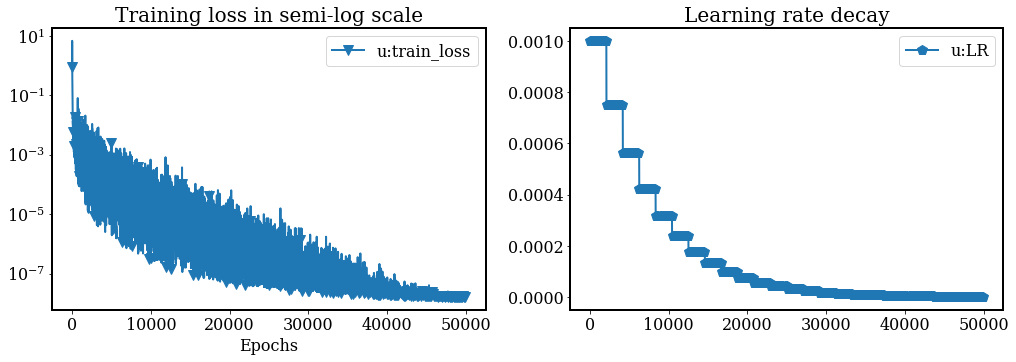

In [22]:
## Visualize training
u_lstm.lstm.summary()

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,9),constrained_layout=True)

num_epochs_u = np.arange(n_epochs_lstm)

ax[0,0].semilogy(num_epochs_u,loss_u,label='u:train_loss',marker='v',markevery=128)
ax[0,0].set_title('Training loss in semi-log scale')

ax[0,1].plot(num_epochs_u,lr_u,label='u:LR',marker='p',markevery=128)
ax[0,1].set_title('Learning rate decay')

for i in range(1):
    ax[i,0].legend(); ax[i,1].legend()
    ax[i,0].set_xlabel('Epochs') 
ax[1,1].remove()
ax[1,0].remove()



In [23]:
### Predict using data points not in training set
p_num = 2
print("Computing predictions for Re = %f"%param_train[p_num])
u_test = snap_data[p_num]['burgers'][:,:snap_end[p_num]+1].T
u_shift_test = shifted_snap[p_num]['burgers'][:,:snap_end[p_num]+1].T

if scaling:
    u_test, u_shift_test, _, _ = du.data_scaler(u_test, u_shift_test, u_max, u_min)

u_test = np.hstack(( u_test, param_train[p_num]/p_max*np.ones((u_test.shape[0],1)) ))
u_shift_test = np.hstack(( u_shift_test, param_train[p_num]/p_max*np.ones((u_shift_test.shape[0],1)) ))

    
encoded_u_test = u_autoencoder.encoder(u_test).numpy()
if augment_out:
    decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()[:,:-1]
else:
    decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()


Computing predictions for Re = 300.000000


In [24]:
direct_prediction = True

if scaling_lstm:
    encoded_u_test_scaled, _,_,_  = du.data_scaler(encoded_u_test, encoded_u_test, umax_latent, umin_latent)
else:
    encoded_u_test_scaled = encoded_u_test
encoded_u_test_sigma = du.augment_state(encoded_u_test_scaled, [param_train[p_num]/p_max], {0:Nt_train[p_num]})

u_dynamics_test_input, u_dynamics_test_target = tu.split_sequence_multi(encoded_u_test_sigma, lstm_steps)

if direct_prediction:
    u_dynamics_test_pred = u_lstm.lstm(u_dynamics_test_input).numpy()
    t_start = 0
else:
    ### roll over prediction
    encoded_test_sigma = du.augment_state(encoded_u_test, [param_train[p_num]/p_max], {0:Nt_train[p_num]})
    u_dynamics_test_input, u_dynamics_test_target = tu.split_sequence_multi(encoded_test_sigma, lstm_steps)
    t_start = np.random.choice(times_offline[p_num].size-5*lstm_steps)
    print("Computing predictions from t = %.2f"%(times_offline[p_num][t_start+lstm_steps]))
    u_dynamics_test = u_dynamics_test_input[t_start]
    u_dynamics_test_pred = np.zeros((times_offline[p_num].size-lstm_steps-t_start,latent_dim_u+1))

    for nt in np.arange(times_offline[p_num].size-lstm_steps-t_start):
        if nt%50 == 0: print("Evaluating model at Time Step %d"%(nt+1+lstm_steps+t_start))
        u_dynamics_test_pred[nt,:] = u_lstm.predict(u_dynamics_test.reshape((1, lstm_steps,latent_dim_u+1)))
        u_dynamics_test = np.roll(u_dynamics_test,lstm_steps-1,axis=0)
        u_dynamics_test[-1,:] = u_dynamics_test_pred[nt,:]


In [25]:
if scaling_lstm:
    u_dynamics_test_pred_unscaled  = du.scaler_inverse(u_dynamics_test_pred, umax_latent, umin_latent, scaling=scaling_lstm)
else:
    u_dynamics_test_pred_unscaled  = u_dynamics_test_pred

if augment_out:
    decoded_test_pred = u_autoencoder.decoder(u_dynamics_test_pred_unscaled[:,:-1]).numpy()[:,:-1]
else:
    decoded_test_pred = u_autoencoder.decoder(u_dynamics_test_pred_unscaled).numpy()

pred = {}
pred['burgers'] = du.scaler_inverse(decoded_test_pred[:,:], u_max, u_min, scaling=scaling).T


In [26]:
## Compare LSTM predictions in latent space
if not direct_prediction:
    encoded_truth = encoded_u_test[lstm_steps:,:]; ldim = latent_dim_u; 
    encoded_pred = u_dynamics_test_pred_unscaled
    tn_start = times_offline[p_num][lstm_steps+t_start]
    num_rows = np.maximum(encoded_truth.shape[1],3)

    fig, ax = plt.subplots(nrows=num_rows,ncols=1,figsize=(7,num_rows*2.2),)
    fig.tight_layout();  fig.subplots_adjust(top=0.9)
    for i in range(num_rows):
        tt1 = ax[i].plot(times_offline[p_num][lstm_steps:snap_end[p_num]+1],encoded_truth[:,i],
                         label='Truth',marker='o',markevery=48)
        tt2 = ax[i].plot(times_offline[p_num][lstm_steps+t_start:],encoded_pred[:,i],
                         label='Pred',marker='s',markevery=61)
        ax[i].set_ylabel('Mode %d'%(i))
    ax[i].set_xlabel('Time')  
    lg = ax[0].legend(ncol=2,bbox_to_anchor=(0.54, 1.48))
    
#     plt.savefig(fig_dir+'Burgers1D_CombAE%sLSTM%d_rolled_t%.2f_AEmodes_Re%.1f_n%d_swish_NMSE_epochs%d.png'%(mnum_ae,mnum_lstm,tn_start,param_train[p_num],ldim,n_epochs_lstm),dpi=300,bbox_inches='tight')



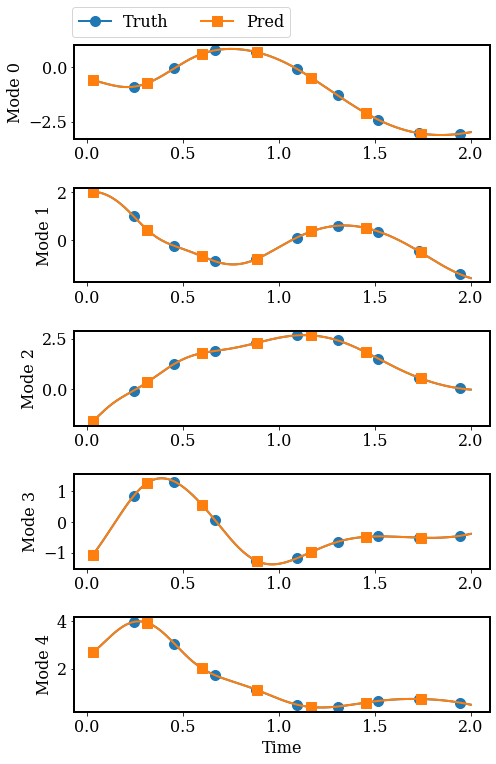

In [27]:
## Compare LSTM predictions in latent space
if direct_prediction:
    encoded_truth = encoded_u_test[lstm_steps:,:]; ldim = latent_dim_u; 
    encoded_pred = u_dynamics_test_pred_unscaled
    num_rows = np.maximum(encoded_truth.shape[1],3)
    
    fig, ax = plt.subplots(nrows=num_rows,ncols=1,figsize=(7,num_rows*2.2),)  
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    for i in range(num_rows):
        tt1 = ax[i].plot(times_offline[p_num][lstm_steps:snap_end[p_num]+1],encoded_truth[:,i],
                         label='Truth',marker='o',markevery=53)
        tt2 = ax[i].plot(times_offline[p_num][lstm_steps:snap_end[p_num]+1],encoded_pred[:,i],
                         label='Pred',marker='s',markevery=71)
        ax[i].set_ylabel('Mode %d'%(i))
    ax[i].set_xlabel('Time') 
    lg = ax[0].legend(ncol=2,bbox_to_anchor=(0.54, 1.48))


#     plt.savefig(fig_dir+'Burgers1D_CombAE%sLSTM%d_direct_AEmodes_Re%.1f_n%d_swish_NMSE_epochs%d.png'%(mnum_ae,mnum_lstm,param_train[p_num],ldim,n_epochs_lstm),dpi=300,bbox_inches='tight')


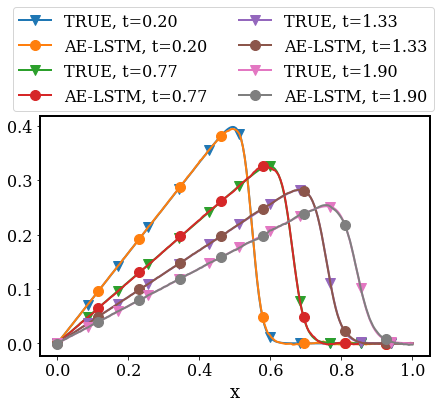

In [28]:
### Visualizing direct reconstruction using true decoder

fig = plt.figure(figsize=(7,6))
ky = soln_names[0]; 
np.random.seed(2021)
fig.tight_layout()
fig.subplots_adjust(top=0.68)


pu.plot_decoded_1d(pred,snap_data[p_num],times_offline[p_num][lstm_steps+t_start:],
                   times_offline[p_num][:],nodes,ky,flag='AE-LSTM',tr_end = 0.95)

# if direct_prediction:
#     plt.savefig(fig_dir+'Burgers1D_CombAE%sLSTM%d_direct_recon_Re%.1f_n%d_swish_NMSE_epochs%d.png'%(mnum_ae,mnum_lstm,param_train[p_num],ldim,n_epochs_lstm),dpi=300,bbox_inches='tight')
# else:
#     plt.savefig(fig_dir+'Burgers1D_CombAE%sLSTM%d_rolled_t%.2f_recon_Re%.1f_n%d_swish_NMSE_epochs%d.png'%(mnum_ae,mnum_lstm,tn_start,param_train[p_num],ldim,n_epochs_lstm),dpi=300,bbox_inches='tight')

 